In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas_datareader import data


In [2]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

In [3]:
dataset_original=pd.read_csv('./indexdatabase/excel_vic.csv', parse_dates=[1])
dataset_original.columns=["Ticker","Date","OpenFixed","HighFixed","LowFixed","close","Volume","Open","High","Low","Close","VolumeDeal","VolumeFB","VolumeFS"]
stock_data = dataset_original.copy()
stock_data.Timestamp=pd.to_datetime(stock_data.Date, format='%d-%m-%Y %H:%M')
stock_data.index = stock_data.Timestamp
stock_data = stock_data.sort_values(by=['Date'], ascending=[True])
stock_data = stock_data.resample('D').fillna(method='ffill')
stock_data.tail()

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 'Date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


,Ticker,Date,OpenFixed,HighFixed,LowFixed,close,Volume,Open,High,Low,Close,VolumeDeal,VolumeFB,VolumeFS
Date,,,,,,,,,,,,,,
2018-10-14,VIC,2018-10-12,93.0,97.5,92.8,96.0,1735640,93.0,97.5,92.8,96.0,97000,585470,746310
2018-10-15,VIC,2018-10-15,96.0,96.7,94.0,95.5,720500,96.0,96.7,94.0,95.5,0,129210,217920
2018-10-16,VIC,2018-10-16,95.0,98.6,94.2,98.6,1290720,95.0,98.6,94.2,98.6,3699398,4014438,4022098
2018-10-17,VIC,2018-10-17,99.0,99.6,98.2,99.0,1310430,99.0,99.6,98.2,99.0,0,50660,985080
2018-10-18,VIC,2018-10-18,98.5,99.2,98.0,99.1,896140,98.5,99.2,98.0,99.1,607130,623190,973130


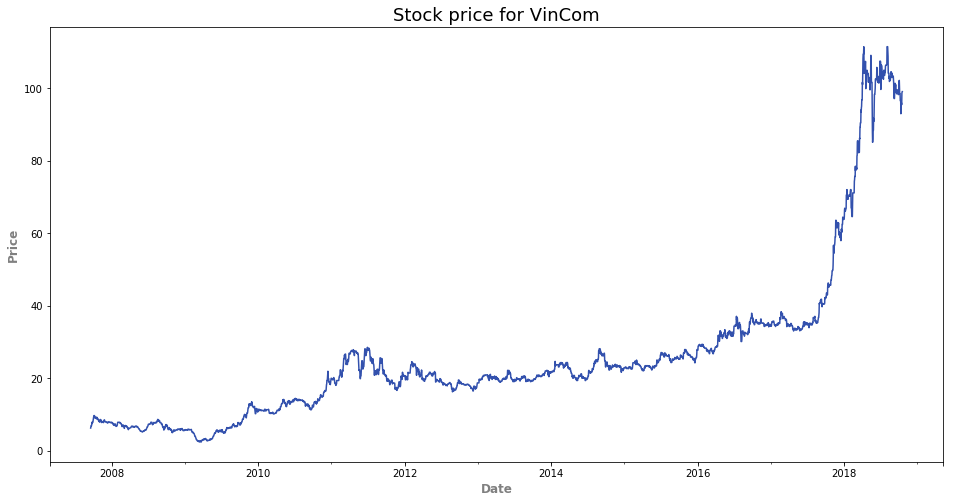

In [4]:
stock_data['close'].plot(figsize=(16,8), color='#002699', alpha=0.8)
plt.xlabel("Date", fontsize=12, fontweight='bold',color='gray')
plt.ylabel("Price", fontsize=12, fontweight='bold', color='gray')
plt.title("Stock price for VinCom", fontsize=18)
plt.show()

In [13]:
def cycle_analysis(data,split_date,cycle,mode='additive',forecast_plot = False,print_ind=False):
    training = data[:split_date].iloc[:-1,]
    testing = data[split_date:]
    predict_period = len(pd.date_range(split_date,max(data.index)))
    df = training.reset_index()
    df.columns = ['ds','y']
    m = Prophet(weekly_seasonality=False,yearly_seasonality=False,daily_seasonality=False)
    m.add_seasonality('self_define_cycle',period=cycle,fourier_order=8,mode=mode)
    m.fit(df)
    future = m.make_future_dataframe(periods=predict_period)
    forecast = m.predict(future)
    if forecast_plot:
        m.plot(forecast)
        plt.plot(testing.index,testing.values,'.',color='#ff3333',alpha=0.6)
        plt.xlabel('Date',fontsize=12,fontweight='bold',color='gray')
        plt.ylabel('Price',fontsize=12,fontweight='bold',color='gray')
        plt.show()
    ret = max(forecast.self_define_cycle)-min(forecast.self_define_cycle)
    model_tb = forecast['yhat']
    model_tb.index = forecast['ds'].map(lambda x:x.strftime("%Y-%m-%d"))
    out_tb = pd.concat([testing,model_tb],axis=1)
    out_tb = out_tb[~out_tb.iloc[:,0].isnull()]
    out_tb = out_tb[~out_tb.iloc[:,1].isnull()]
    mse = mean_squared_error(out_tb.iloc[:,0],out_tb.iloc[:,1])
    rep = [ret,mse]
    if print_ind:
        print("Projected return per cycle: {}".format(round(rep[0],2)))
        print("MSE: {}".format(round(rep[1],4)))
    return rep

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


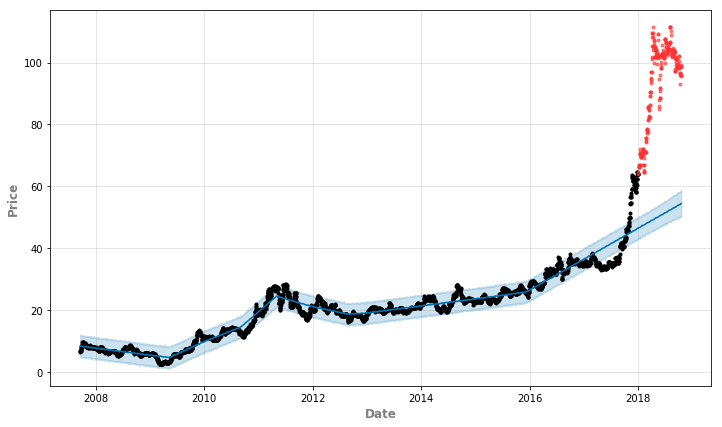

Projected return per cycle: 0.21
MSE: 2038.3803


[0.21180404443538292, 2038.3803366274194]

In [14]:
cycle_analysis(stock_data['close'], '2018-01-01',30, forecast_plot=True, print_ind=True)

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


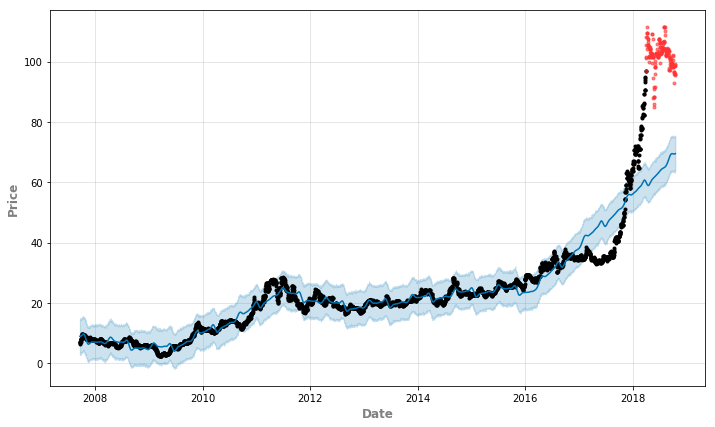

Projected return per cycle: 3.36
MSE: 1483.8799


[3.3601543990755043, 1483.8799449853252]

In [16]:
cycle_analysis(stock_data['close'], '2018-04-01',293, forecast_plot=True, print_ind=True)

In [20]:
testing_box = range(10, 301)
return_box = []
mse_box = []
for c in testing_box:
    f = cycle_analysis(stock_data['close'], '2018-04-01', c)
    return_box.append(f[0])
    mse_box.append(f[1])
    

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/home/trungnuyen/anaconda2/envs/fbprophet/l

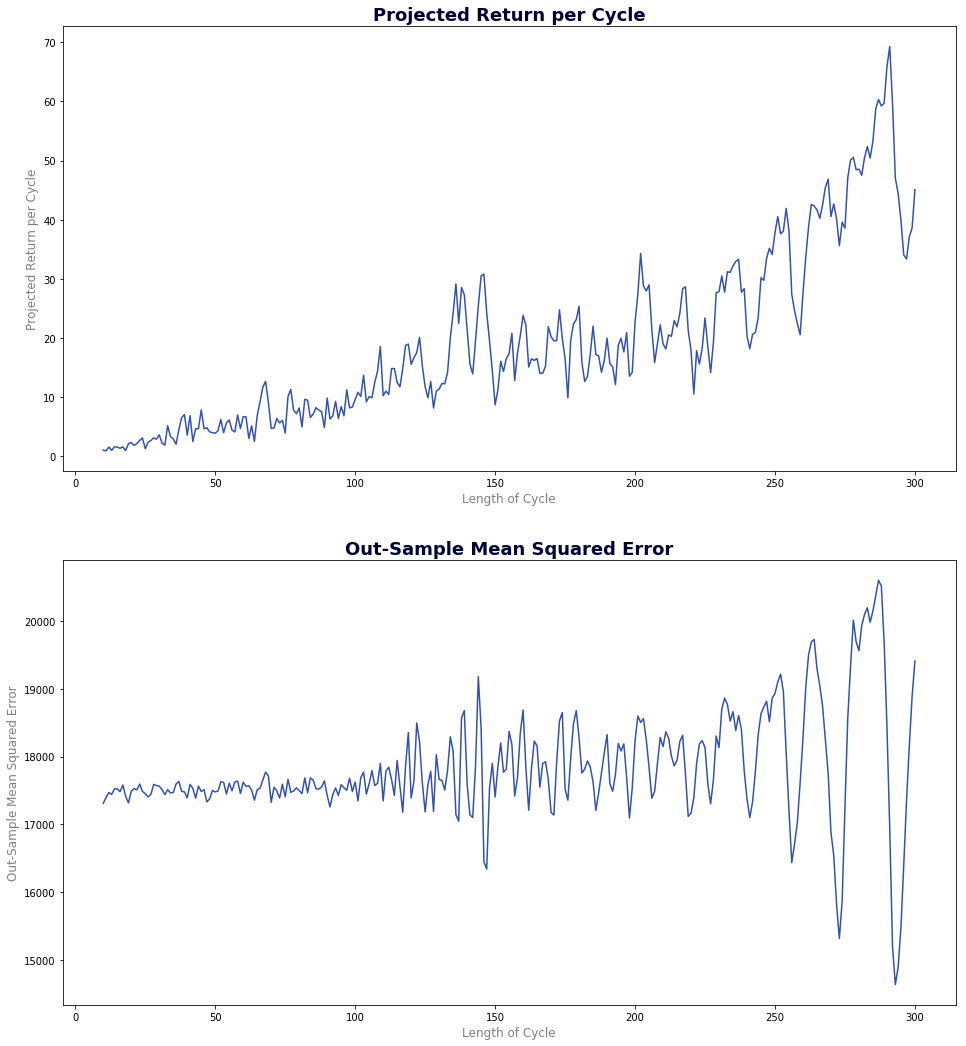

In [21]:
f = plt.figure(figsize=(16,18))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)
ax.plot(testing_box,return_box,color='#002699',alpha=0.8)
ax2.plot(testing_box,mse_box,color='#002699',alpha=0.8)
ax.set_xlabel("Length of Cycle",fontsize=12,color='gray')
ax2.set_xlabel("Length of Cycle",fontsize=12,color='gray')
ax.set_ylabel("Projected Return per Cycle",fontsize=12,color='gray')
ax2.set_ylabel("Out-Sample Mean Squared Error",fontsize=12,color='gray')
ax.set_title("Projected Return per Cycle",fontsize=18,fontweight='bold',color='#000033')
ax2.set_title("Out-Sample Mean Squared Error",fontsize=18,fontweight='bold',color='#000033')
plt.show()

In [22]:
report = pd.DataFrame({'cycle':testing_box,'return':return_box,'mse':mse_box})
possible_choice = report[report['return'] >10]
possible_choice[possible_choice['mse']==min(possible_choice['mse'])]

,cycle,return,mse
283,293,47.039137,14636.628359
